In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from scipy.sparse import bsr_matrix
from scipy.sparse.linalg import cg

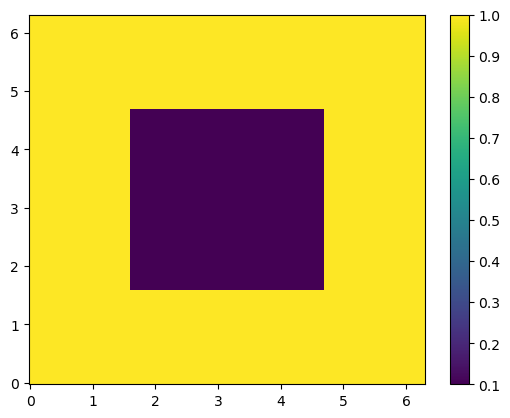

In [2]:
L = 2*np.pi
N = 129 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
def a_function(x,y):
    a = np.where((x>np.pi/2)&(x<3*np.pi/2)&(y>np.pi/2)&(y<3*np.pi/2), 0.1, 1)
    return a
Z = a_function(XY[0].flatten(),XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()

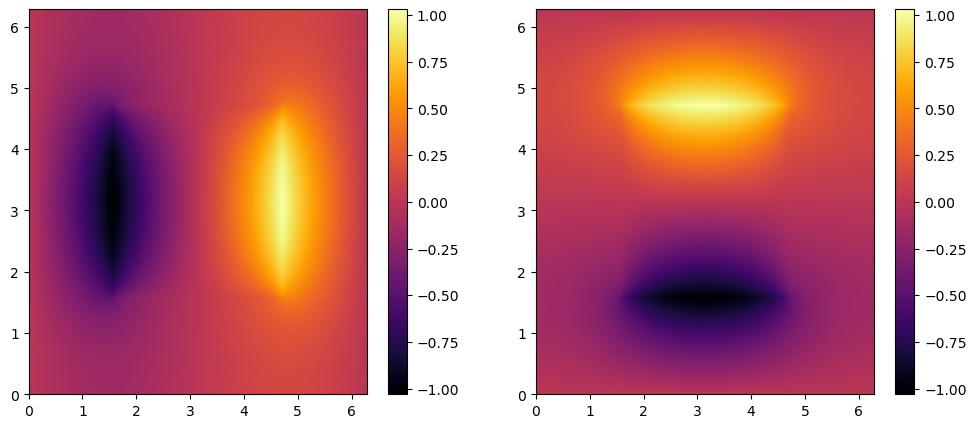

In [3]:
x1 = XY[0].flatten()
x2 = XY[1].flatten()
triang = Triangulation(x1,x2)
f1 = np.argwhere(x2 == 0).flatten()
f2 = np.argwhere(x2 == L).flatten()
f3 = np.argwhere(x1 == 0).flatten()
f4 = np.argwhere(x1 == L).flatten()
A_matrix = lambda x1, x2 : a_function(x1, x2) * np.eye(2)
xi = np.eye(2)
Q = np.array([[0, -1], [1, 0]])
# Construct global stiffness matrix K 
n_elem = len(triang.triangles)
n_nodes = len(x1)
K = np.zeros((n_nodes, n_nodes))
K_inv = np.zeros((n_nodes, n_nodes))
f = np.zeros((n_nodes, 2))
f_inv = np.zeros((n_nodes, 2))
for i in range(n_elem):
    elem = triang.triangles[i]
    node_coords_x1 = x1[elem]
    node_coords_x2 = x2[elem]
    vector_x1 = node_coords_x1[1:]-node_coords_x1[:-1]
    vector_x2 = node_coords_x2[1:]-node_coords_x2[:-1]
    vectors = np.column_stack((vector_x1, vector_x2, [0, 0]))
    area = (1/2) * abs(np.cross(vectors[0], vectors[1])[-1])
    center = [np.mean(node_coords_x1), np.mean(node_coords_x2)]
    M = np.column_stack(([1, 1, 1], node_coords_x1, node_coords_x2))
    M_inv = np.linalg.inv(M)
    D_grad = M_inv[1:]
    D_curl = np.zeros((2, 3))
    D_curl[0] = -D_grad[1]
    D_curl[1] = D_grad[0]
    A = A_matrix(center[0], center[1])
    A_inv = np.linalg.inv(A)
    K_elem = area * D_grad.T @ A @ D_grad
    K_inv_elem = area * D_curl.T @ A_inv @ D_curl
    K[np.ix_(elem, elem)] += K_elem
    K_inv[np.ix_(elem, elem)] += K_inv_elem
    f_elem = -area * D_grad.T @ A @ xi
    f_inv_elem = -area * D_curl.T @ A_inv @ xi
    f[elem] += f_elem
    f_inv[elem] += f_inv_elem
# Find unique nodes belonging to the master and copy faces in the periodic BCs
master_nodes = np.union1d(f1, f3)
master_nodes = np.setdiff1d(master_nodes, f2)
master_nodes = np.setdiff1d(master_nodes, f4)
copy_nodes = np.union1d(f2, f4)
copy_nodes = np.setdiff1d(copy_nodes, master_nodes)
free_nodes = np.setdiff1d(np.arange(n_nodes), copy_nodes)
n_master = len(master_nodes)
n_free = len(free_nodes)
K_copy = K.copy()
K_copy[:,f1] += K_copy[:,f2]
K_copy[f1,:] += K_copy[f2,:]
K_copy[:,f3] += K_copy[:,f4]
K_copy[f3,:] += K_copy[f4,:]
K_per = K_copy[np.ix_(free_nodes, free_nodes)]

K_inv_copy = K_inv.copy()
K_inv_copy[:,f1] += K_inv_copy[:,f2]
K_inv_copy[f1,:] += K_inv_copy[f2,:]
K_inv_copy[:,f3] += K_inv_copy[:,f4]
K_inv_copy[f3,:] += K_inv_copy[f4,:]
K_inv_per = K_inv_copy[np.ix_(free_nodes, free_nodes)]
f_copy = f.copy()
f_copy[f1] += f_copy[f2]
f_copy[f3] += f_copy[f4]
f_per = f_copy[free_nodes]

f_inv_copy = f_inv.copy()
f_inv_copy[f1] += f_inv_copy[f2]
f_inv_copy[f3] += f_inv_copy[f4]
f_inv_per = f_inv_copy[free_nodes]
U_per_1 = cg(bsr_matrix(K_per), f_per[:,0], tol=1e-6)
U_per_2 = cg(bsr_matrix(K_per), f_per[:,1], tol=1e-6)
W_per_1 = cg(bsr_matrix(K_inv_per), f_inv_per[:,0], tol=1e-6)
W_per_2 = cg(bsr_matrix(K_inv_per), f_inv_per[:,1], tol=1e-6)
U = np.zeros((n_nodes,2))
W = np.zeros((n_nodes,2))
U[free_nodes, 0] = U_per_1[0]
U[free_nodes, 1] = U_per_2[0]
W[free_nodes, 0] = W_per_1[0]
W[free_nodes, 1] = W_per_2[0]
U[f2] = U[f1]
U[f4] = U[f3]
W[f2] = W[f1]
W[f4] = W[f3]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
pos1 = axs[0].pcolormesh(XY[0], XY[1], U[:,0].reshape(N, N), cmap='inferno', shading='gouraud')
pos2 = axs[1].pcolormesh(XY[0], XY[1], U[:,1].reshape(N, N), cmap='inferno', shading='gouraud')
fig.colorbar(pos1, ax=axs[0])
fig.colorbar(pos2, ax=axs[1])

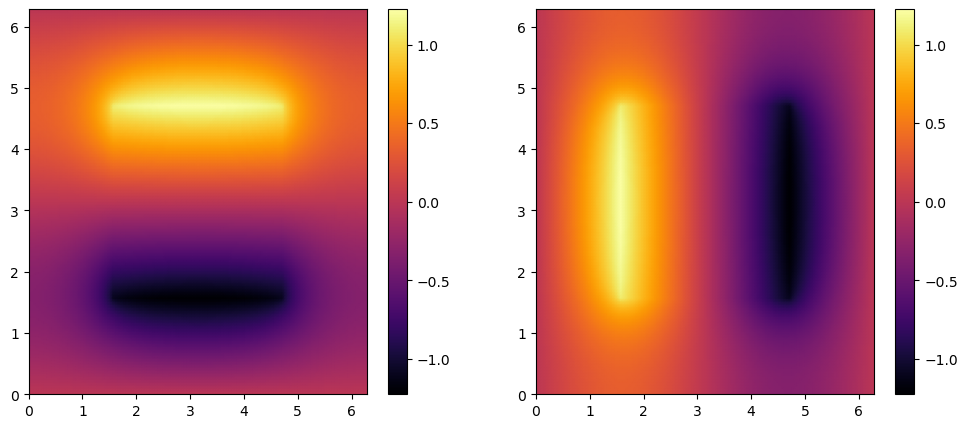

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
pos1 = axs[0].pcolormesh(XY[0], XY[1], W[:,0].reshape(N, N), cmap='inferno', shading='gouraud')
pos2 = axs[1].pcolormesh(XY[0], XY[1], W[:,1].reshape(N, N), cmap='inferno', shading='gouraud')
fig.colorbar(pos1, ax=axs[0])
fig.colorbar(pos2, ax=axs[1])

In [5]:
# Compute the A_h, B_h2 - upper and lower bounds to the homogenized parameters
A_h = np.zeros((2,2))
B_h = np.zeros((2,2))
for i in range(n_elem):
    elem = triang.triangles[i]
    node_coords_x1 = x1[elem]
    node_coords_x2 = x2[elem]
    vector_x1 = node_coords_x1[1:]-node_coords_x1[:-1]
    vector_x2 = node_coords_x2[1:]-node_coords_x2[:-1]
    vectors = np.column_stack((vector_x1, vector_x2, [0, 0]))
    area = (1/2) * abs(np.cross(vectors[0], vectors[1])[-1])
    center = [np.mean(node_coords_x1), np.mean(node_coords_x2)]
    A = A_matrix(center[0], center[1])
    A_inv = np.linalg.inv(A)
    M = np.column_stack(([1, 1, 1], node_coords_x1, node_coords_x2))
    M_inv = np.linalg.inv(M)
    D_grad = M_inv[1:]
    D_curl = np.zeros((2, 3))
    D_curl[0] = -D_grad[1]
    D_curl[1] = D_grad[0]
    g_elem = D_grad @ U[elem] + xi
    curl = D_curl @ W[elem] + xi  
    A_h_elem = area * g_elem.T @ A @ g_elem
    A_h += A_h_elem
    B_h_elem = area * curl.T @ A_inv @ curl
    B_h += B_h_elem

A_l = np.linalg.inv(B_h / L**2)
A_u = A_h / L**2

print(A_l)
print(A_u)

np.save(f'bounds/exact/A_l_fem_{N}.npy', A_l)
np.save(f'bounds/exact/A_u_fem_{N}.npy', A_u)

[[6.47325391e-01 6.05830734e-16]
 [6.12017377e-16 6.47325391e-01]]
[[ 6.47826958e-01 -1.64954735e-16]
 [-1.64998676e-16  6.47826958e-01]]


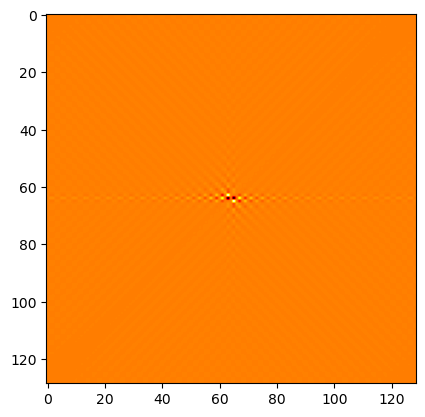

In [15]:
F = np.fft.fft2(U[:,0].reshape(N, N))
F_shifted = np.fft.fftshift(F)
plt.imshow(F_shifted.real, cmap='hot')

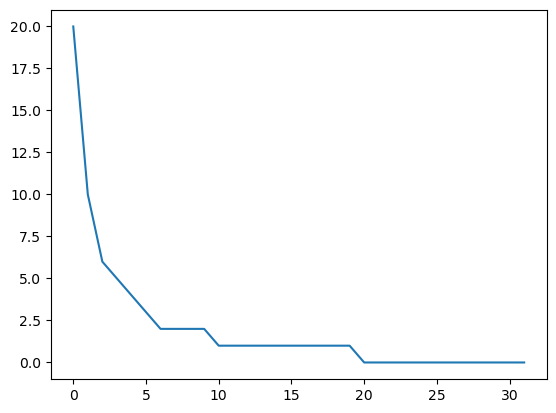

In [42]:
x = np.arange(32)
y = 20 // (x+1)
plt.plot(x, y)

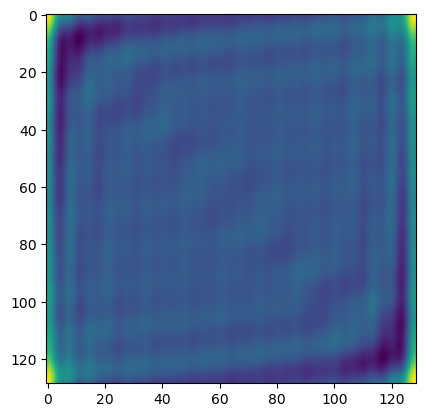

In [70]:
func = lambda x, m, n: np.cos(m*x[0]+n*x[1])
N_x = 33
N_y = 33
Z = np.zeros_like(XY)[0]
for m in range(1, N_x):
    for n in range(20//(m+1)):
        if (m!=0) or (n!=0):
            Z += func(XY, m, n)

plt.imshow(Z)

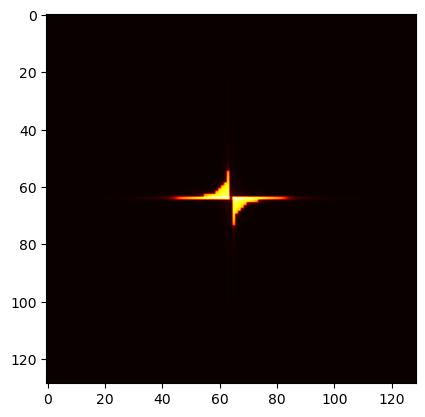

In [71]:
Z_fft = np.fft.fft2(Z)
Z_shifted = np.fft.fftshift(Z_fft)
plt.imshow(Z_shifted.real.__abs__(), cmap='hot')

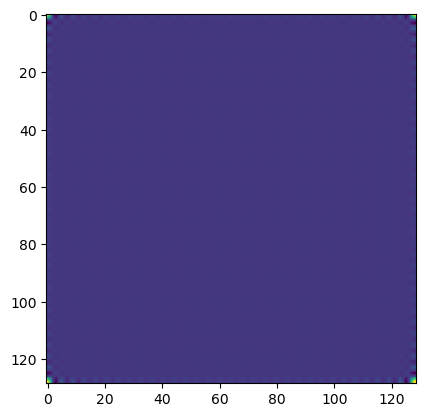

In [91]:
func1 = lambda x, m, n: np.cos(m*x[0]+n*x[1])
func2 = lambda x, m, n: np.cos(m*x[0]-n*x[1])
N_x = 33
N_y = 33
Z = np.zeros_like(XY)[0]
for m in range(N_x):
    for n in range(N_y):
        Z += func1(XY, m, n)
        Z += func2(XY, m, n)

plt.imshow(Z)

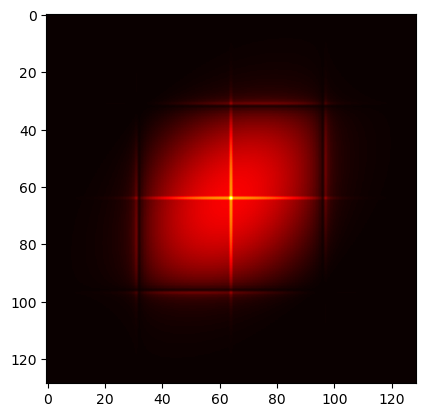

In [92]:
Z_fft = np.fft.fft2(Z)
Z_shifted = np.fft.fftshift(Z_fft)
plt.imshow(Z_shifted.real.__abs__(), cmap='hot')

In [76]:
kx = np.fft.fftfreq(N)
ky = np.fft.fftfreq(N)
kx, ky = np.meshgrid(kx, ky)

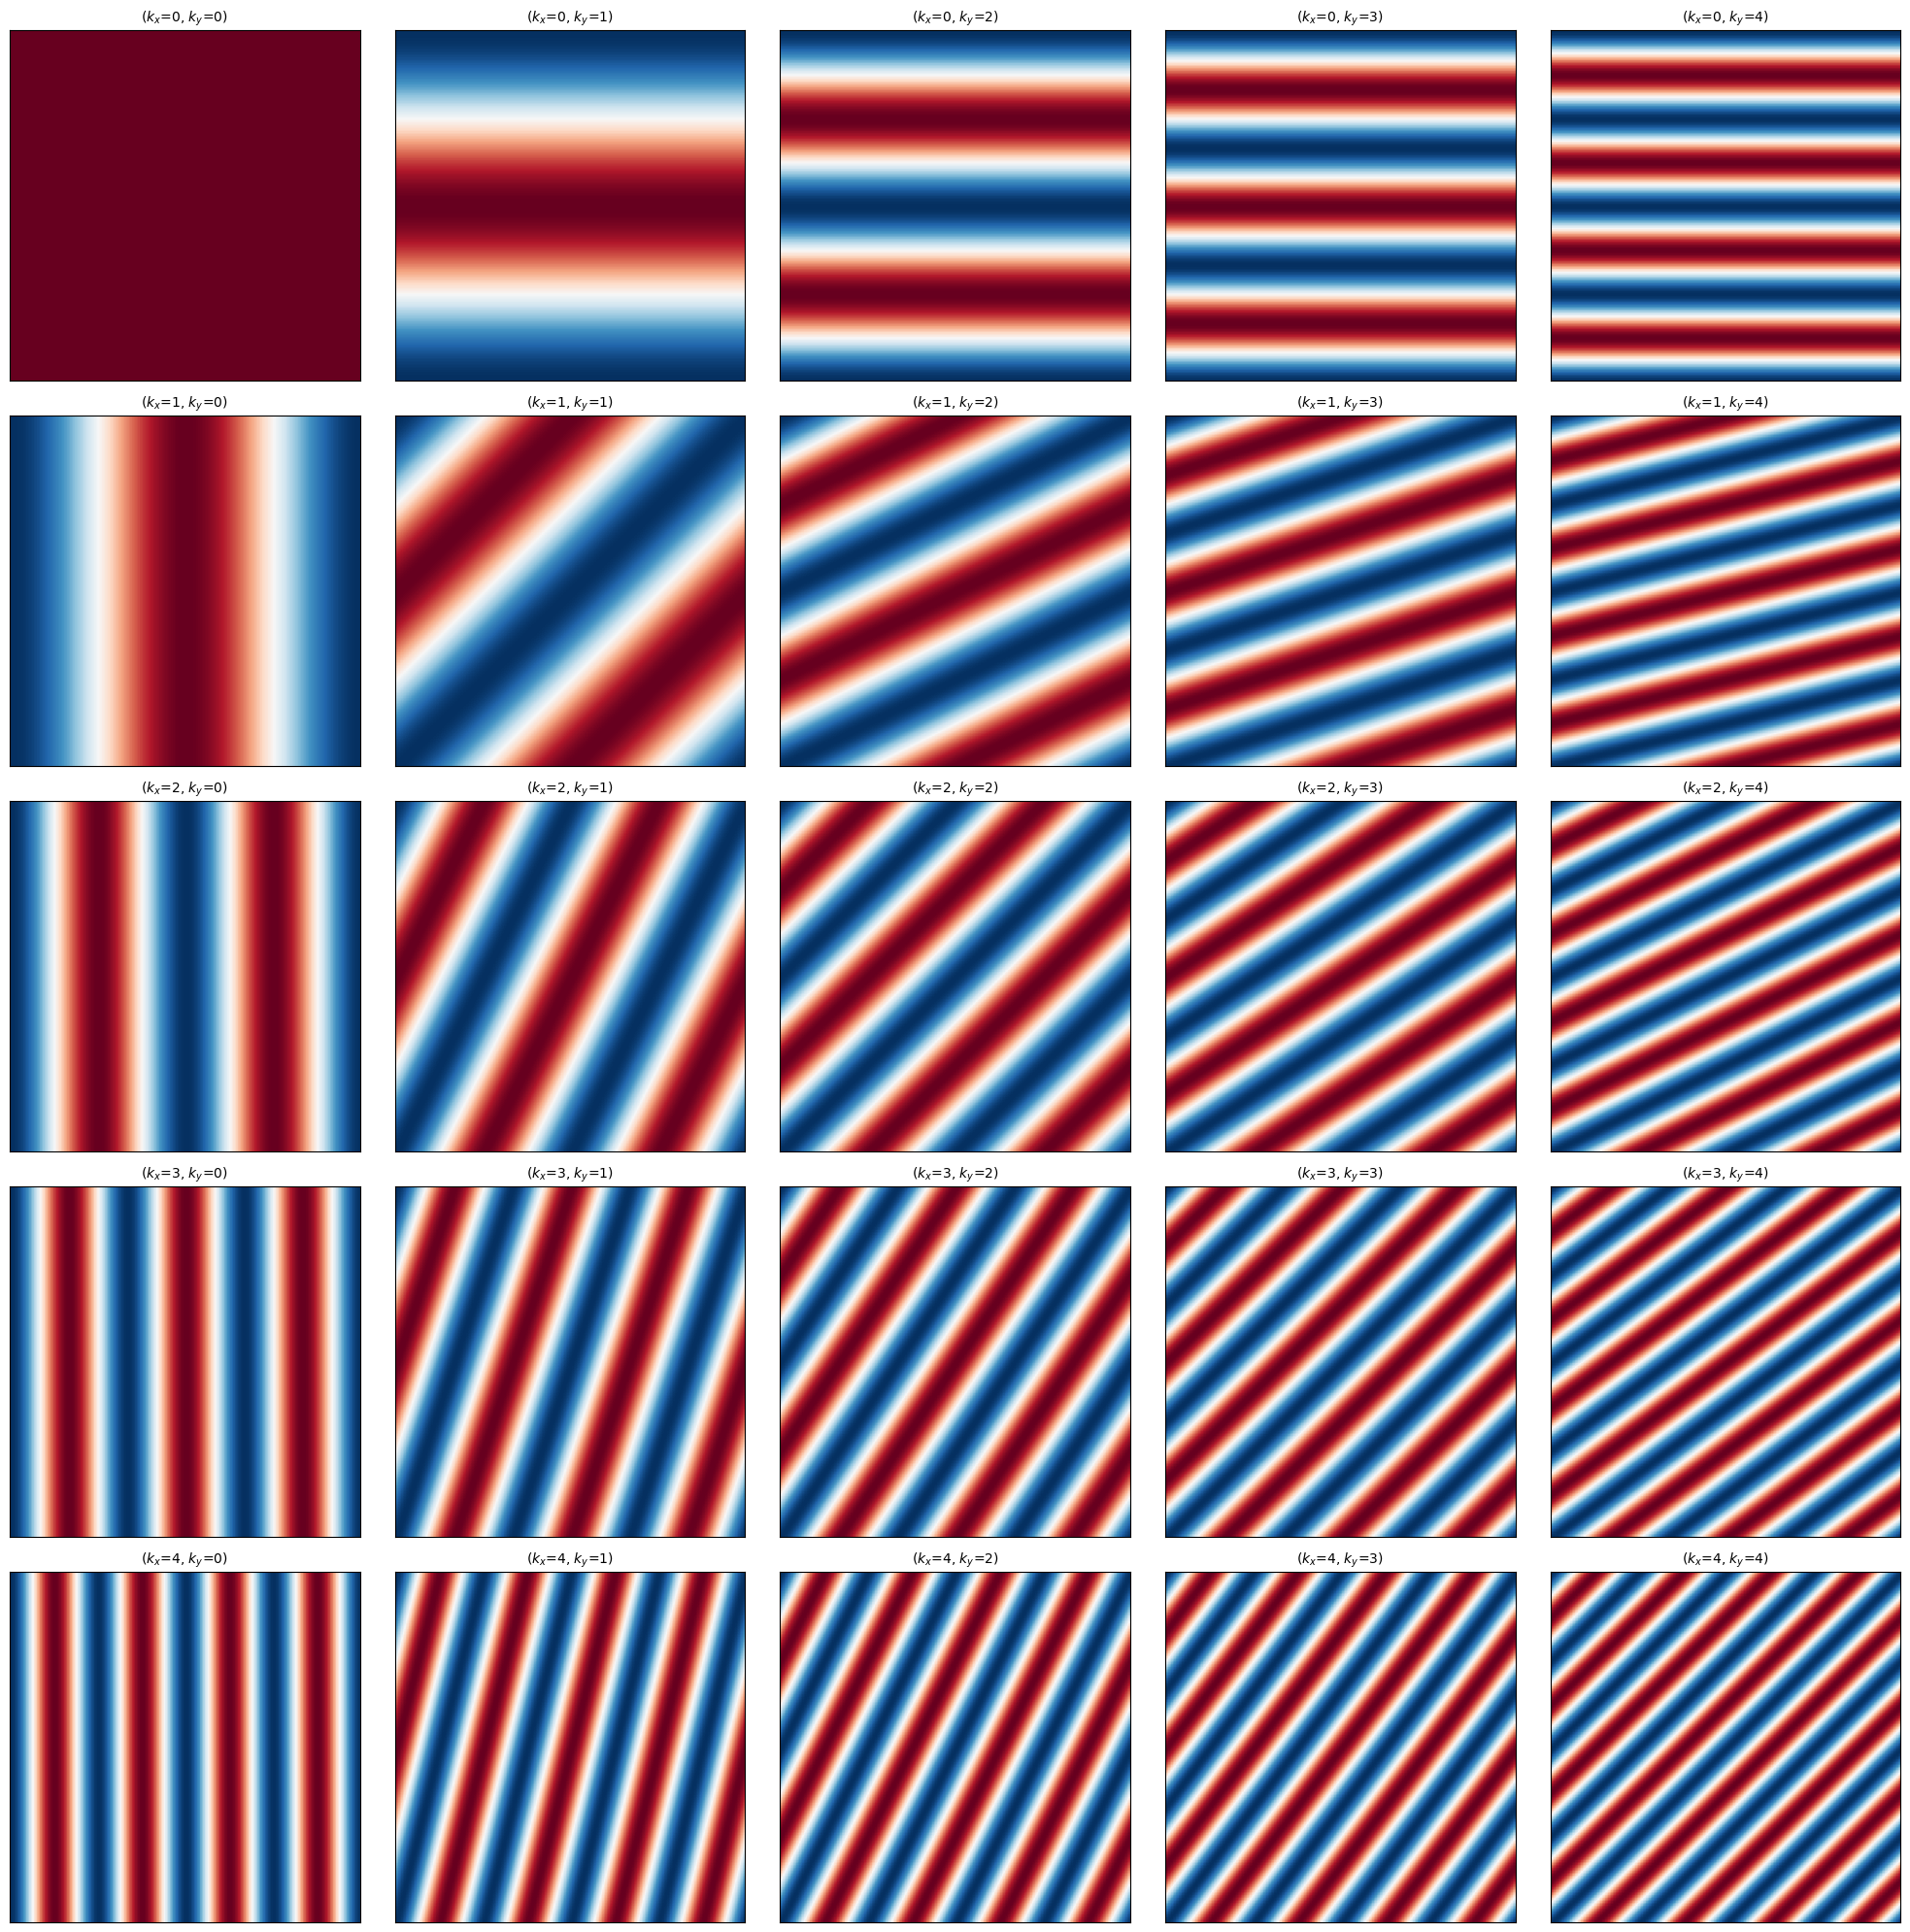

In [11]:
x = np.arange(N)
y = np.arange(N)
X, Y = np.meshgrid(x, y)

fig, axes = plt.subplots(5, 5, figsize=(20, 20))

for kx in range(5):
    for ky in range(5):
        # Create the basis function
        basis = np.exp(2j * np.pi * (kx * X + ky * Y) / N)
        
        # Plot the real part
        axes[kx, ky].imshow(basis.real, cmap='RdBu', extent=(0, N, 0, N))
        axes[kx, ky].set_xticks([])
        axes[kx, ky].set_yticks([])
        axes[kx, ky].set_title(f"($k_x$={kx}, $k_y$={ky})", fontsize=10)

plt.tight_layout()
plt.show()

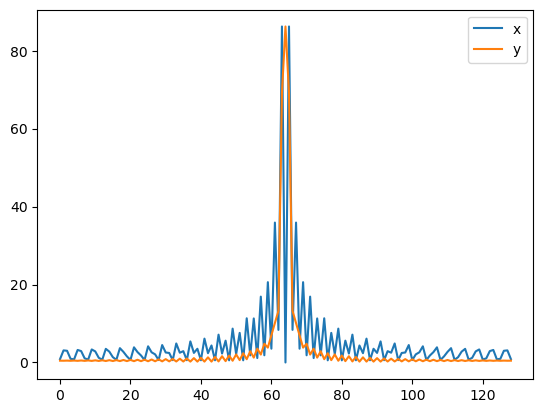

In [74]:
plt.plot(F_shifted.real.__abs__().max(axis=0))
plt.plot(F_shifted.real.__abs__().max(axis=1))
plt.legend(['x', 'y'])

In [16]:
kx = np.fft.fftshift(np.fft.fftfreq(N))
ky = np.fft.fftshift(np.fft.fftfreq(N))
kx, ky = np.meshgrid(kx, ky)

In [ ]:
np.fft.fftfreq(N)

array([ 0.        ,  0.00775194,  0.01550388,  0.02325581,  0.03100775,
        0.03875969,  0.04651163,  0.05426357,  0.0620155 ,  0.06976744,
        0.07751938,  0.08527132,  0.09302326,  0.10077519,  0.10852713,
        0.11627907,  0.12403101,  0.13178295,  0.13953488,  0.14728682,
        0.15503876,  0.1627907 ,  0.17054264,  0.17829457,  0.18604651,
        0.19379845,  0.20155039,  0.20930233,  0.21705426,  0.2248062 ,
        0.23255814,  0.24031008,  0.24806202,  0.25581395,  0.26356589,
        0.27131783,  0.27906977,  0.28682171,  0.29457364,  0.30232558,
        0.31007752,  0.31782946,  0.3255814 ,  0.33333333,  0.34108527,
        0.34883721,  0.35658915,  0.36434109,  0.37209302,  0.37984496,
        0.3875969 ,  0.39534884,  0.40310078,  0.41085271,  0.41860465,
        0.42635659,  0.43410853,  0.44186047,  0.4496124 ,  0.45736434,
        0.46511628,  0.47286822,  0.48062016,  0.48837209,  0.49612403,
       -0.49612403, -0.48837209, -0.48062016, -0.47286822, -0.46

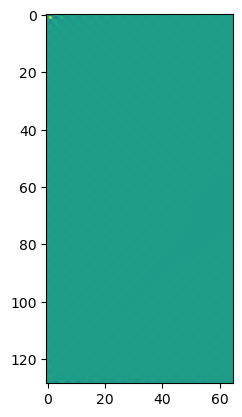

In [10]:
plt.imshow(fft.real)

In [ ]:
plt.plot()